* ***Supervised Learning Task:*** The column 'Target Buy' stands for if certian customer will purchase something due to some promotion campaign. So the question is whether we can use some customers responses to this compaign to predict someone else's reactions? If we can achieve this, company could promote the campaign to customers that are more likely to accept the offer and make some purchase which could help it make more efficient marketing plan. This helps marketers optimize anything from email send frequency, to sales staff time, to money, including discounts.

* ***Unsupervised Learning Task:*** The dataset also gives us some information about customers(Including their basic information and purchasing preference, Campaign data). So we could perform Customer Personality Analysis to help find company’s ideal customers. It helps company to better understand its customers and makes it easier for them to make proper market plans, like modifying and promoting products for different customers according to the specific needs, behaviors and concerns.

In [1]:
#Import all required libraries
!pip install openpyxl
import pandas as pd
import numpy as np
from functools import reduce
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
from matplotlib import colors
from matplotlib.colors import ListedColormap
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78"])
from collections import Counter

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras import Model

!pip install lifetimes
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.2/242.2 KB 3.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 KB 5.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 KB 4.2 MB/s eta 0:00:00


In [2]:
#Read the dataset
file1 = pd.read_excel('../input/reuters/Analytical DATASET.XLSX',sheet_name='Customer Profile Data (DS#1)')
file2 = pd.read_excel('../input/reuters/Analytical DATASET.XLSX',sheet_name='Past Purchase Data (Ds#2)')
file3 = pd.read_excel('../input/reuters/Analytical DATASET.XLSX',sheet_name='Campaign Coverage Data (DS#3)')
file4 = pd.read_excel('../input/reuters/Analytical DATASET.XLSX',sheet_name='Month Level Customer Data (DS#4')
file2.head()

,Customer_ID,Count_of_Transactions,Loyalty_Tier,Avg_Basket_Size,Reward_Points_Earned
0,1,39,Silver,245.552821,46406
1,2,37,Silver,273.410270,47591
2,3,36,Silver,381.080000,42632
3,4,32,Bronze,187.551875,15731
4,5,39,Bronze,196.355128,11909


In [3]:
file1.drop(['Previous_Default_Flag','Loan_Availed_Flag','House_Owned_Flag','job'],axis=1,inplace=True)
file1.head()

,Customer_ID,age,marital_status,education,Income_USD,Credit_rating,Life_Stage_Code,Ethnicity,Employment
0,1,85,married,basic.4y,10307,Poor,Tradinationalist,African American,retired
1,2,50,married,basic.9y,33232,Fair,Baby Boomers,African American,employed
2,3,47,single,basic.4y,12167,Fair,Baby Boomers,African American,employed
3,4,26,divorced,professional.course,26459,Good,Gen Y,African American,employed
4,5,52,married,university.degree,22328,Good,Baby Boomers,African American,retired


In [4]:
file2.drop(['Avg_Basket_Size','Reward_Points_Earned'],axis=1,inplace=True)
file2.head()

,Customer_ID,Count_of_Transactions,Loyalty_Tier
0,1,39,Silver
1,2,37,Silver
2,3,36,Silver
3,4,32,Bronze
4,5,39,Bronze


In [5]:
file3.drop(['month_last_contacted','day_of_week_last_contacted','days_elapsed_last_contact','buy_decision_flag','Campaign_Start_Date'],axis=1,inplace=True)
file3.head()

,Customer_ID,Mode_of_contact,duration_last_contact,num_of_contact_campaign,num_contact_before_campaigning,outcome_last_campaign,Duration_of_last_contact_type,Num_of_contact_campaign_type,Num_contact_before_campaign_type,Target_buy
0,1,flyers,165,3,0,nonexistent,Short,Average,Average,0
1,2,mailers,43,2,0,nonexistent,Short,Average,Average,0
2,3,flyers,369,1,0,nonexistent,Long,Once,Average,0
3,4,flyers,500,1,0,nonexistent,Long,Once,Average,1
4,5,flyers,172,1,1,failure,Short,Once,Once,0


In [6]:
file4 = pd.DataFrame(file4.groupby('Customer_ID',as_index=False).agg({
    'Revenue': lambda x: x.sum()
}))
file4.head()

,Customer_ID,Revenue
0,1,9576.56
1,2,10116.18
2,3,13718.88
3,4,6001.66
4,5,7657.85


In [7]:
dataframes = [file1,file2,file4,file3]
#Apply a function of two arguments cumulatively to the items of a sequence, from left to right, so as to reduce the sequence to a single value.
data = reduce(lambda left,right: pd.merge(left,right,on=['Customer_ID']),dataframes)
data.head()

,Customer_ID,age,marital_status,education,Income_USD,Credit_rating,Life_Stage_Code,Ethnicity,Employment,Count_of_Transactions,...,Revenue,Mode_of_contact,duration_last_contact,num_of_contact_campaign,num_contact_before_campaigning,outcome_last_campaign,Duration_of_last_contact_type,Num_of_contact_campaign_type,Num_contact_before_campaign_type,Target_buy
0,1,85,married,basic.4y,10307,Poor,Tradinationalist,African American,retired,39,...,9576.56,flyers,165,3,0,nonexistent,Short,Average,Average,0
1,2,50,married,basic.9y,33232,Fair,Baby Boomers,African American,employed,37,...,10116.18,mailers,43,2,0,nonexistent,Short,Average,Average,0
2,3,47,single,basic.4y,12167,Fair,Baby Boomers,African American,employed,36,...,13718.88,flyers,369,1,0,nonexistent,Long,Once,Average,0
3,4,26,divorced,professional.course,26459,Good,Gen Y,African American,employed,32,...,6001.66,flyers,500,1,0,nonexistent,Long,Once,Average,1
4,5,52,married,university.degree,22328,Good,Baby Boomers,African American,retired,39,...,7657.85,flyers,172,1,1,failure,Short,Once,Once,0


In [8]:
#Information on features
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5148 entries, 0 to 5147
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Customer_ID                       5148 non-null   int64  
 1   age                               5148 non-null   int64  
 2   marital_status                    5148 non-null   object 
 3   education                         5148 non-null   object 
 4   Income_USD                        5148 non-null   int64  
 5   Credit_rating                     5148 non-null   object 
 6   Life_Stage_Code                   5148 non-null   object 
 7   Ethnicity                         5148 non-null   object 
 8   Employment                        5148 non-null   object 
 9   Count_of_Transactions             5148 non-null   int64  
 10  Loyalty_Tier                      5148 non-null   object 
 11  Revenue                           5148 non-null   float64
 12  Mode_o

In [9]:
print(data.marital_status.value_counts())
#Segmenting Marital Status in two groups
data.marital_status = data.marital_status.replace({'married':'Together','single':'Alone','divorced':'Alone'})
print(data.marital_status.value_counts())

married     3171
single      1401
divorced     564
unknown       12
Name: marital_status, dtype: int64
Together    3171
Alone       1965
unknown       12
Name: marital_status, dtype: int64


In [10]:
print(data.education.value_counts())
#Segmenting Education levels
data.education = data.education.replace({'basic.9y':'UnderGraduation','basic.4y':'UnderGraduation','basic.6y':'UnderGraduation','university.degree':'Graduation',
                                         'high.school':'Graduation'})
print(data.education.value_counts())

university.degree      1534
high.school            1328
basic.9y                764
professional.course     643
basic.4y                571
basic.6y                305
illiterate                3
Name: education, dtype: int64
Graduation             2862
UnderGraduation        1640
professional.course     643
illiterate                3
Name: education, dtype: int64


In [11]:
print(data.Employment.value_counts())
data.Employment = data.Employment.replace({'self employed':'employed'})
print(data.Employment.value_counts())

employed         4311
self employed     354
unemployed        278
retired           205
Name: Employment, dtype: int64
employed      4665
unemployed     278
retired        205
Name: Employment, dtype: int64


# *Z-SCORE METHOD FOR OUTLIER DETECTION* 

* The Z-score(also called the standard score) is an important concept in statistics that indicates how far away a certain point is from the mean.
* Zscore = (X − Mean) / StandardDeviation
* It assumes that the data is normally distributed and hence the % of data points that lie between -/+1 stdev. is ~68%, -/+2 stdev. is ~95% and -/+3 stdev. is ~99.7%. Hence, if the Z-score is >3 we can safely mark that point to be an outlier.

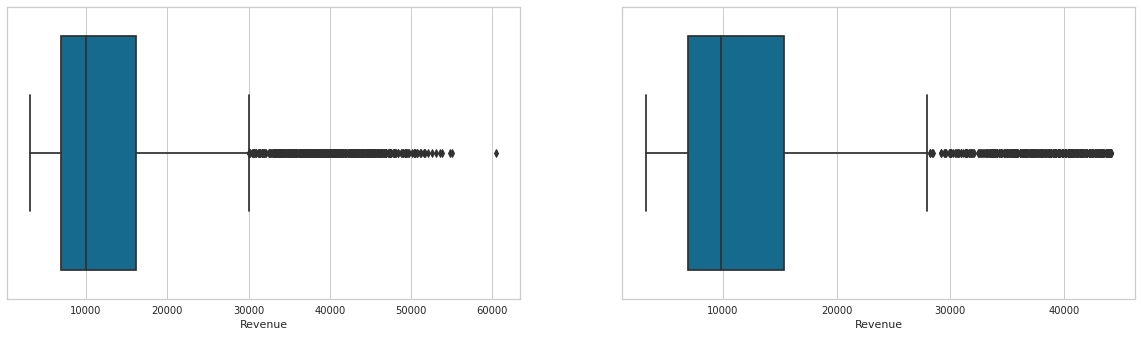

In [12]:
z_outliers = []
z_index = []

for item in data.Revenue:
    z = ( item - np.mean(data.Revenue) ) / np.std(data.Revenue)
    if z>3:
        z_outliers.append(item) 

for item in z_outliers:
    z_index.append( list(data[data.Revenue==item].index)[0] )

fig,(ax0,ax1) = plt.subplots(1,2,figsize=(18,5))
sns.boxplot(x=data.Revenue,ax=ax0);
sns.boxplot(x=data.Revenue.drop(index=z_index),ax=ax1);

# *IQR METHOD*

In this method by using Inter Quartile Range(IQR), we detect outliers. IQR tells us the variation in the data set.Any value, which is beyond the range of -1.5 x IQR to 1.5 x IQR treated as outliers
* Q1 represents the 1st quartile/25th percentile of the data.
* Q2 represents the 2nd quartile/median/50th percentile of the data.
* Q3 represents the 3rd quartile/75th percentile of the data.
* (Q1–1.5*IQR) represent the smallest value in the data set and (Q3+1.5*IQR) represnt the largest value in the data set.

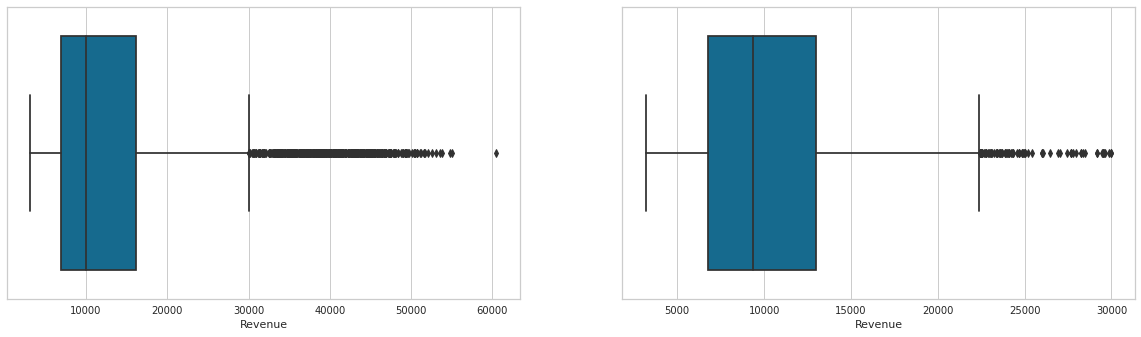

In [13]:
iqr_outliers = []
iqr_index = []

q1 = data.Revenue.quantile(0.25)
q3 = data.Revenue.quantile(0.75)
iqr = q3 - q1
Lower_tail = q1 - 1.5 * iqr
Upper_tail = q3 + 1.5 * iqr
for item in data.Revenue:
    if item < Lower_tail or item > Upper_tail:
        iqr_outliers.append(item)

for item in iqr_outliers:
    iqr_index.append( list(data[data.Revenue==item].index)[0] )

fig,(ax0,ax1) = plt.subplots(1,2,figsize=(18,5))
sns.boxplot(x=data.Revenue,ax=ax0);
sns.boxplot(x=data.Revenue.drop(index=iqr_index),ax=ax1);

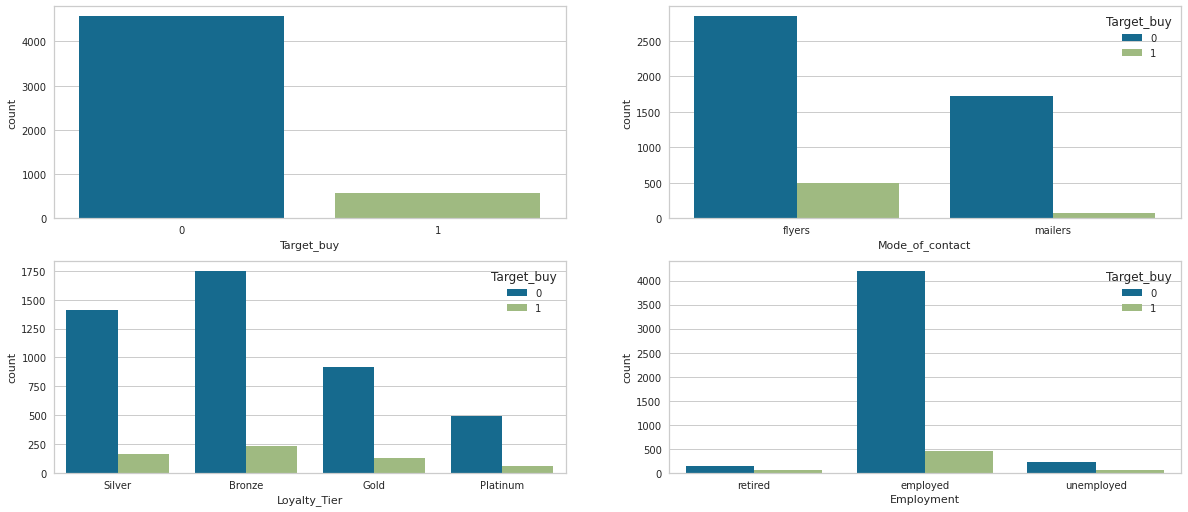

In [14]:
f,ax=plt.subplots(2,2,figsize=(18,8))
sns.countplot('Target_buy',data=data,ax=ax[0,0]);
sns.countplot('Mode_of_contact',data=data,ax=ax[0,1], hue='Target_buy');
sns.countplot('Loyalty_Tier',data=data,ax=ax[1,0], hue='Target_buy');
sns.countplot('Employment',data=data,ax=ax[1,1], hue='Target_buy');

In [15]:
categorical_columns = data.select_dtypes(include=['object'])
categorical_columns.columns

Index(['marital_status', 'education', 'Credit_rating', 'Life_Stage_Code',
       'Ethnicity', 'Employment', 'Loyalty_Tier', 'Mode_of_contact',
       'outcome_last_campaign', 'Duration_of_last_contact_type',
       'Num_of_contact_campaign_type', 'Num_contact_before_campaign_type'],
      dtype='object')

In [16]:
#Converting the labels into a numeric form so as to convert them into the machine-readable form
encoder = LabelEncoder()
for column in categorical_columns.columns:
    data[column] = encoder.fit_transform(data[column])
data.head()

,Customer_ID,age,marital_status,education,Income_USD,Credit_rating,Life_Stage_Code,Ethnicity,Employment,Count_of_Transactions,...,Revenue,Mode_of_contact,duration_last_contact,num_of_contact_campaign,num_contact_before_campaigning,outcome_last_campaign,Duration_of_last_contact_type,Num_of_contact_campaign_type,Num_contact_before_campaign_type,Target_buy
0,1,85,1,1,10307,4,4,0,1,39,...,9576.56,0,165,3,0,1,2,0,0,0
1,2,50,1,1,33232,1,0,0,0,37,...,10116.18,1,43,2,0,1,2,0,0,0
2,3,47,0,1,12167,1,0,0,0,36,...,13718.88,0,369,1,0,1,0,2,0,0
3,4,26,0,3,26459,2,3,0,0,32,...,6001.66,0,500,1,0,1,0,2,0,1
4,5,52,1,0,22328,2,0,0,1,39,...,7657.85,0,172,1,1,0,2,2,2,0


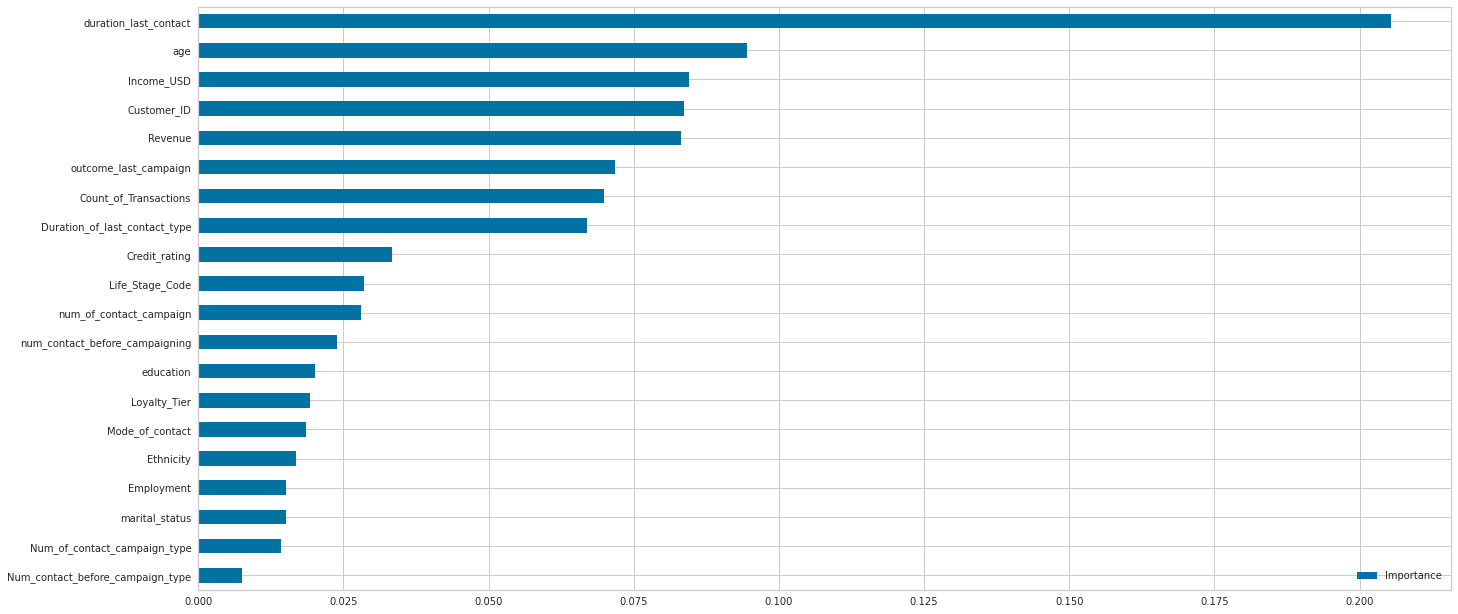

In [17]:
#Using Random Forest to gain an insight on Feature Importance
clf = RandomForestClassifier()
clf.fit(data.drop('Target_buy', axis=1), data['Target_buy'])

importance = clf.feature_importances_
importance = pd.DataFrame(importance, index=data.drop('Target_buy', axis=1).columns, columns=["Importance"])
importance.sort_values(by='Importance', ascending=True).plot(kind='barh', figsize=(20,len(importance)/2));

In [18]:
#Upon initially exploring the data, the first thing we noticed was the imbalance in the labels.
data['Target_buy'].value_counts()

0    4566
1     582
Name: Target_buy, dtype: int64

In [19]:
xtrain = data.drop(['Customer_ID'],axis=1)[:4500]
ytrain = data['Target_buy'].values[:4500]
xtest = data.drop(['Customer_ID'],axis=1)[4500:]
ytest = data['Target_buy'].values[4500:]

print('Train: ', len(xtrain))
print('Test: ',  len(xtest))
print('N/P Sample: ', Counter(ytrain))

#A problem with imbalanced classification is that there are too few examples of the minority class for a model to effectively learn the decision boundary.
sm = SMOTE(random_state=2)
#One way to solve this problem is to oversample the examples in the minority class.
xtrain, ytrain = sm.fit_resample(xtrain, ytrain)

print('Train: ', len(xtrain))
print('Test: ',  len(xtest))
print('N/P Sample: ', Counter(ytrain))

Train:  4500
Test:  648
N/P Sample:  Counter({0: 3990, 1: 510})
Train:  7980
Test:  648
N/P Sample:  Counter({0: 3990, 1: 3990})


In [20]:
kfold = 4

reg_cv_results_acc1 = cross_val_score(LogisticRegression(), xtrain, ytrain, cv=kfold, scoring='accuracy')   
"K-fold ACC: %f" % (reg_cv_results_acc1.mean())

'K-fold ACC: 0.726441'

In [21]:
kfold = 3

rf_cv_results_acc = cross_val_score(RandomForestClassifier(), xtrain, ytrain, cv=kfold, scoring='accuracy')   
"K-fold ACC: %f" % (rf_cv_results_acc.mean())

'K-fold ACC: 0.887218'

In [22]:
#Standardizes a feature by subtracting the mean and then scaling to unit variance
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
scaled_data

array([[-1.73171439,  4.27424691,  0.77420875, ..., -0.98927684,
        -0.3582302 , -0.35702082],
       [-1.73104149,  0.95961943,  0.77420875, ..., -0.98927684,
        -0.3582302 , -0.35702082],
       [-1.73036858,  0.6755085 , -1.2665627 , ...,  1.00985846,
        -0.3582302 , -0.35702082],
       ...,
       [ 1.73036858,  0.58080486,  0.77420875, ..., -0.98927684,
        -0.3582302 , -0.35702082],
       [ 1.73104149, -0.55563885, -1.2665627 , ...,  0.01029081,
        -0.3582302 , -0.35702082],
       [ 1.73171439,  1.14902671,  0.77420875, ..., -0.98927684,
        -0.3582302 , -0.35702082]])

# *PCA*
The higher the number of features, the harder it is to work with it. Many of these features are correlated, and hence redundant. This is why will be performing dimensionality reduction on the selected features before putting them through a classifier.
Dimensionality reduction is the process of reducing the number of random variables under consideration, by obtaining a set of principal variables.

In [23]:
#Transformation of data
pca = PCA(n_components=3)
pca_data = pd.DataFrame(pca.fit_transform(scaled_data),columns=['pca1', 'pca2', 'pca3'])
pca_data.head()

,pca1,pca2,pca3
0,-3.108856,-0.900389,-0.528518
1,-2.966641,-1.930908,-0.339323
2,-2.942294,0.434724,1.001025
3,-3.174767,2.613088,2.157681
4,-3.033740,1.830637,-3.865650


In [24]:
#Input Lyer
input_df = Input(shape =(data.shape[1],))
#Encoding
x = Dense(500, activation = 'relu')(input_df)
x = Dense(500, activation = 'relu')(x)
x = Dense(2000, activation = 'relu')(x)
#Decoding
encoded = Dense(2000, activation = 'relu')(x)
x = Dense(500, activation = 'relu')(encoded)
x = Dense(500, activation = 'relu')(x)
#Output Layer
decoded = Dense(data.shape[1])(x)

#autoencoder
autoencoder = Model(input_df, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

2022-04-21 13:12:06.704170: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


An autoencoder is a regression task where the network is asked to predict its input. These networks has a tight bottleneck of a few neurons in the middle, forcing them to create effective representations that compress the input into a low dimensional code that can be used by the decoder to reproduce the original input.

In [25]:
autoencoder.fit(data,data,batch_size=128,epochs=100,verbose=3)

2022-04-21 13:12:07.190273: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78

In [26]:
encoded_data = autoencoder.predict(scaled_data)

# *Clustering*
Steps involved in the Clustering:
* Elbow Method to determine the number of clusters to be formed
* Clustering
* Examining the clusters formed via scatter plot

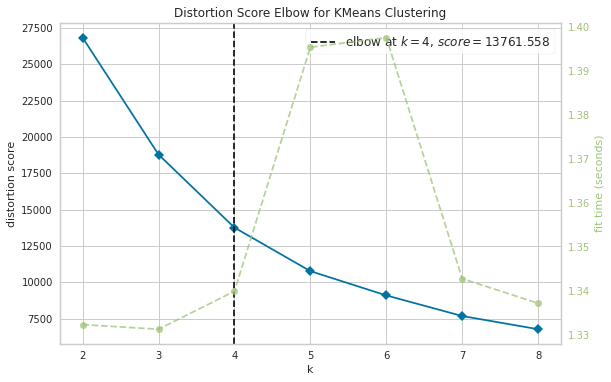

In [27]:
#Elbow method to find numbers of clusters to make
elbow = KElbowVisualizer(KMeans(), k=8)
elbow.fit(pca_data)
elbow.show();

In [28]:
kmeans = KMeans(4)
kmeans.fit(encoded_data)
labels = kmeans.labels_
y = kmeans.fit_predict(scaled_data)
pca_data['Cluster'] = y
#Adding the cluster to original dataset
data['Cluster'] = y

In [29]:
data['Cluster'].value_counts()

3    2410
1    1366
0     835
2     537
Name: Cluster, dtype: int64

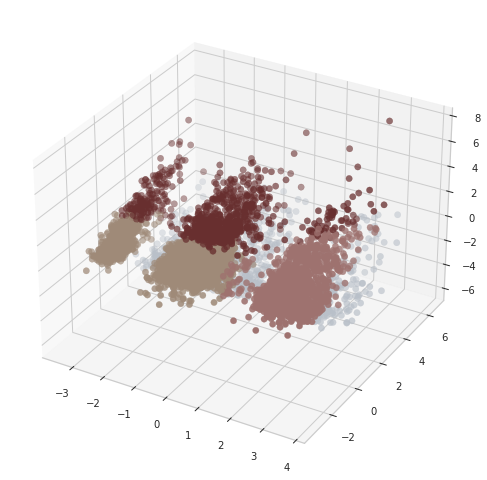

In [30]:
#3-D distribution of the clusters
plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')
ax.scatter3D(pca_data['pca1'],pca_data['pca2'],pca_data['pca3'],c=pca_data['Cluster'],cmap=cmap,marker='o',s=40);

In [31]:
def boxplot_for_clusters(col):
    sns.boxplot(data=data, x=col, y='Revenue', hue='Cluster')

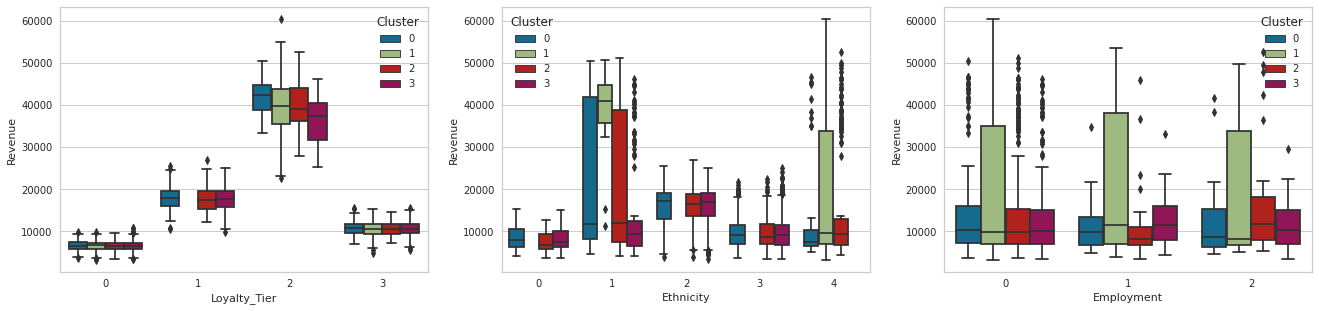

In [32]:
fig = plt.figure(figsize=(20,10))
fig.add_subplot(231); boxplot_for_clusters('Loyalty_Tier')
fig.add_subplot(232); boxplot_for_clusters('Ethnicity')
fig.add_subplot(233); boxplot_for_clusters('Employment')

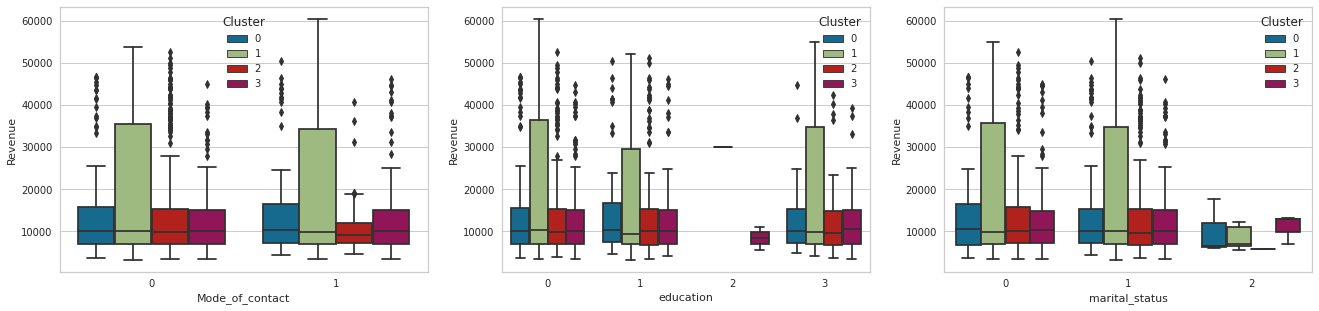

In [33]:
fig = plt.figure(figsize=(20,10))
fig.add_subplot(231); boxplot_for_clusters('Mode_of_contact')
fig.add_subplot(232); boxplot_for_clusters('education')
fig.add_subplot(233); boxplot_for_clusters('marital_status')

# *RFM*
* Recency(R): How recently customers have made their purchases.
* Frequency(F): How often customers have made their purchases.
* Monetary(M): How much money customers have paid for their purchases.

In [34]:
rfm_data = data[['Customer_ID','duration_last_contact','Revenue','Count_of_Transactions']]
rfm_data.head()

,Customer_ID,duration_last_contact,Revenue,Count_of_Transactions
0,1,165,9576.56,39
1,2,43,10116.18,37
2,3,369,13718.88,36
3,4,500,6001.66,32
4,5,172,7657.85,39


In [35]:
quantile = rfm_data[['duration_last_contact','Revenue','Count_of_Transactions']].quantile([.2, .4, .6, .8]).to_dict()
quantile

{'duration_last_contact': {0.2: 88.0, 0.4: 144.0, 0.6: 218.0, 0.8: 368.0},
 'Revenue': {0.2: 6577.580000000001,
  0.4: 8458.996000000001,
  0.6: 11504.060000000001,
  0.8: 18024.544000000005},
 'Count_of_Transactions': {0.2: 47.0, 0.4: 59.0, 0.6: 69.0, 0.8: 94.0}}

In [36]:
#Benchmark to give score for recency indicator
def recency_score(item):
    if item <= quantile['duration_last_contact'][.2]:
        return 5
    elif item <= quantile['duration_last_contact'][.4]:
        return 4
    elif item <= quantile['duration_last_contact'][.6]:
        return 3
    elif item <= quantile['duration_last_contact'][.8]:
        return 2
    else:
        return 1

#Benchmark to give score for frequency & monetary indicator
def frequency_monetary_score(item,compute):
    if item <= quantile[compute][.2]:
        return 1
    elif item <= quantile[compute][.4]:
        return 2
    elif item <= quantile[compute][.6]:
        return 3
    elif item <= quantile[compute][.8]:
        return 4
    else:
        return 5 

In [37]:
rfm_data['R'] = rfm_data['duration_last_contact'].apply(lambda x: recency_score(x))
rfm_data['M'] = rfm_data['Revenue'].apply(lambda x: frequency_monetary_score(x, 'Revenue'))
rfm_data['F'] = rfm_data['Count_of_Transactions'].apply(lambda x: frequency_monetary_score(x, 'Count_of_Transactions'))
rfm_data['RFM_Score'] = rfm_data['R'].map(str) + rfm_data['F'].map(str) + rfm_data['M'].map(str)
rfm_data.head()

,Customer_ID,duration_last_contact,Revenue,Count_of_Transactions,R,M,F,RFM_Score
0,1,165,9576.56,39,3,3,1,313
1,2,43,10116.18,37,5,3,1,513
2,3,369,13718.88,36,1,4,1,114
3,4,500,6001.66,32,1,1,1,111
4,5,172,7657.85,39,3,2,1,312


# *Customer Segmentation*

In [38]:
segmentation_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at risk',
    r'[1-2]5': 'can\'t loose',
    r'3[1-2]': 'about to sleep',
    r'33': 'need attention',
    r'[3-4][4-5]': 'loyal',
    r'41': 'promising',
    r'51': 'new',
    r'[4-5][2-3]': 'loyalists',
    r'5[4-5]': 'champions'
}

rfm_data['Segment'] = rfm_data['R'].map(str) + rfm_data['F'].map(str)
rfm_data['Segment'] = rfm_data['Segment'].replace(segmentation_map,regex=True)
rfm_data.head()

,Customer_ID,duration_last_contact,Revenue,Count_of_Transactions,R,M,F,RFM_Score,Segment
0,1,165,9576.56,39,3,3,1,313,about to sleep
1,2,43,10116.18,37,5,3,1,513,new
2,3,369,13718.88,36,1,4,1,114,hibernating
3,4,500,6001.66,32,1,1,1,111,hibernating
4,5,172,7657.85,39,3,2,1,312,about to sleep


* Champions: Bought recently, buy often and spend the most
* Loyal Customers: Buy on a regular basis. Responsive to promotions.
* Potential Loyalist: Recent customers with average frequency.
* Recent Customers: Bought most recently, but not often.
* Promising: Recent shoppers, but haven’t spent much.
* Customers Needing Attention: Above average recency, frequency and monetary values. May not have bought very recently though.
* About To Sleep: Below average recency and frequency. Will lose them if not reactivated.
* At Risk: Purchased often but a long time ago. Need to bring them back!
* Can’t Lose Them: Used to purchase frequently but haven’t returned for a long time.
* Hibernating: Last purchase was long back and low number of orders. May be lost.

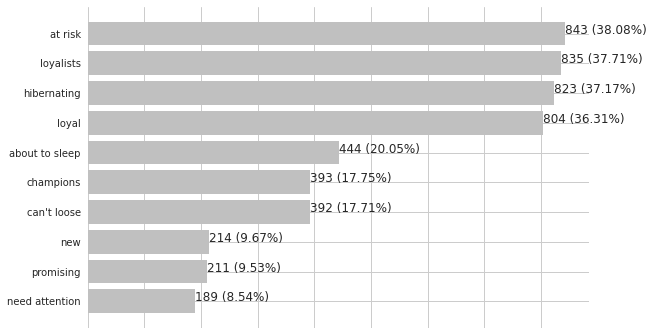

In [39]:
def segmentation_plot(segment):
    seg_counts = segment.value_counts().sort_values(ascending=True)
    fig, ax = plt.subplots()

    bars = ax.barh(range(len(seg_counts)), seg_counts, color='silver')
    ax.set_frame_on(False)
    ax.tick_params(left=False, bottom=False, labelbottom=False)
    ax.set_yticks(range(len(seg_counts)))
    ax.set_yticklabels(seg_counts.index)
    
    for i,bar in enumerate(bars):
        value = bar.get_width()
        ax.text(value,bar.get_y() + bar.get_height()/2, '{:,} ({:}%)'.format(int(value), round(value*100/2214,2)))
    
segmentation_plot(rfm_data['Segment'])

In [40]:
data = data.merge(rfm_data.drop(['duration_last_contact','Revenue','Count_of_Transactions'],axis=1),how='left',on='Customer_ID')
data.head()

,Customer_ID,age,marital_status,education,Income_USD,Credit_rating,Life_Stage_Code,Ethnicity,Employment,Count_of_Transactions,...,Duration_of_last_contact_type,Num_of_contact_campaign_type,Num_contact_before_campaign_type,Target_buy,Cluster,R,M,F,RFM_Score,Segment
0,1,85,1,1,10307,4,4,0,1,39,...,2,0,0,0,3,3,3,1,313,about to sleep
1,2,50,1,1,33232,1,0,0,0,37,...,2,0,0,0,3,5,3,1,513,new
2,3,47,0,1,12167,1,0,0,0,36,...,0,2,0,0,0,1,4,1,114,hibernating
3,4,26,0,3,26459,2,3,0,0,32,...,0,2,0,1,0,1,1,1,111,hibernating
4,5,52,1,0,22328,2,0,0,1,39,...,2,2,2,0,2,3,2,1,312,about to sleep


# *Profiling*
We have formed the segments and looked at their purchasing habits. Let's see who all are there in these segments. For that, we will be profiling the segments formed and come to a conclusion about who is our star customer and who needs more attention from the store.

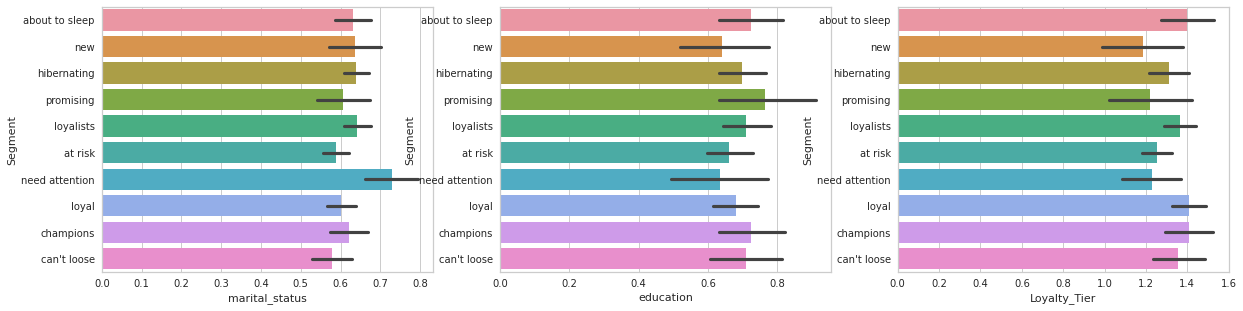

In [41]:
fig = plt.figure(figsize=(18,10))
fig.add_subplot(231); sns.barplot(x='marital_status',y='Segment',data=data);
fig.add_subplot(232); sns.barplot(x='education',y='Segment',data=data);
fig.add_subplot(233); sns.barplot(x='Loyalty_Tier',y='Segment',data=data);

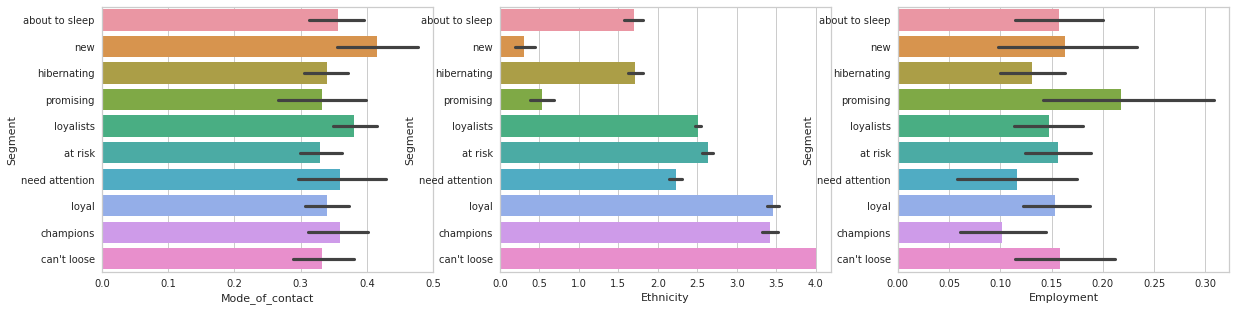

In [42]:
fig = plt.figure(figsize=(18,10))
fig.add_subplot(231); sns.barplot(x='Mode_of_contact',y='Segment',data=data);
fig.add_subplot(232); sns.barplot(x='Ethnicity',y='Segment',data=data);
fig.add_subplot(233); sns.barplot(x='Employment',y='Segment',data=data);

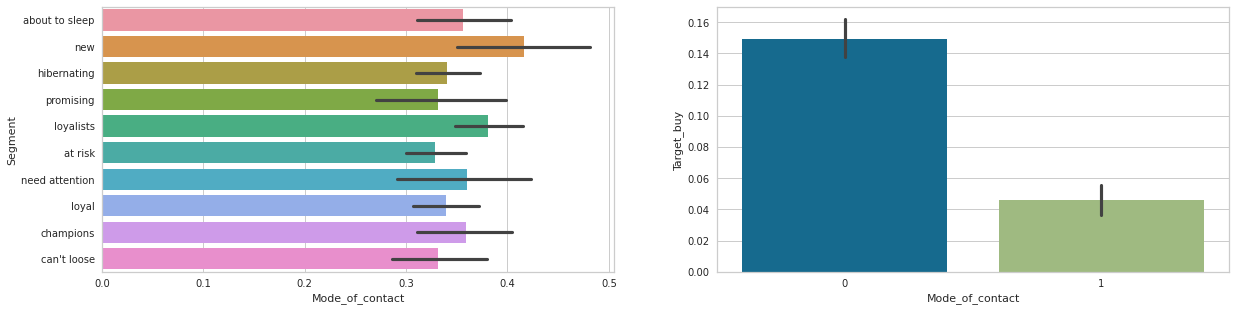

In [43]:
fig = plt.figure(figsize=(18,10))
fig.add_subplot(221); sns.barplot(x='Mode_of_contact',y='Segment',data=data);
fig.add_subplot(222); sns.barplot(x='Mode_of_contact',y='Target_buy',data=data);